In [47]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# !pip install scikit-optimize==0.8
import skopt
from skopt import dump, load
print(skopt.__version__)

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

0.8.0


In [14]:
seed = 1234 # set seed number for reproducible results

In [25]:
ex = pd.read_csv("./examination_bert_result_df.csv")
te = pd.read_csv("./treatment_effect_bert_result_df.csv")
ph = pd.read_csv("./past_history_bert_result_df.csv")

ph = ph.loc[:,["id", "past_history_pred_0", "past_history_pred_1", "label"]].set_index('id')
ex = ex.loc[:,["id", "examination_pred_0", "examination_pred_1", "label"]].set_index('id')
te = te.loc[:,["id", "treatment_effect_pred_0", "treatment_effect_pred_1", "label"]].set_index('id')

df = ph.combine_first(ex)
df = df.combine_first(te)
df

,examination_pred_0,examination_pred_1,label,past_history_pred_0,past_history_pred_1,treatment_effect_pred_0,treatment_effect_pred_1
id,,,,,,,
83,NaN,NaN,0.0,4.145,-4.207,3.898,-4.207
86,NaN,NaN,1.0,-3.523,3.867,-2.310,2.115
164,NaN,NaN,0.0,4.047,-4.008,2.584,-2.740
173,NaN,NaN,1.0,-0.557,0.778,-2.440,2.297
182,2.861,-2.828,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
76037,NaN,NaN,0.0,4.242,-4.332,2.955,-3.172
76139,NaN,NaN,0.0,4.168,-4.190,3.898,-4.220
76247,NaN,NaN,0.0,4.230,-4.355,3.760,-4.113


In [26]:
tmp = df.isna().sum()
tmp[tmp!=0]

examination_pred_0         1685
examination_pred_1         1685
past_history_pred_0         176
past_history_pred_1         176
treatment_effect_pred_0     176
treatment_effect_pred_1     176
dtype: int64

In [27]:
df = df.loc[:,["past_history_pred_0", "past_history_pred_1", "treatment_effect_pred_0", "treatment_effect_pred_1", "examination_pred_0", "examination_pred_1", "label"]]
X = df.loc[:,["past_history_pred_0", "past_history_pred_1", "treatment_effect_pred_0", "treatment_effect_pred_1", "examination_pred_0", "examination_pred_1"]]
y = df.loc[:,"label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y, random_state = seed)

X_train

,past_history_pred_0,past_history_pred_1,treatment_effect_pred_0,treatment_effect_pred_1,examination_pred_0,examination_pred_1
id,,,,,,
13008,4.160,-4.2540,0.6084,-0.8345,3.0470,-2.936
57310,0.436,-0.3086,1.3640,-1.4690,NaN,NaN
39927,4.215,-4.3360,3.7290,-4.0940,NaN,NaN
75459,3.990,-3.9200,3.5590,-3.9060,NaN,NaN
60511,4.246,-4.2850,-2.2930,2.1620,NaN,NaN
...,...,...,...,...,...,...
67355,4.086,-4.1700,3.9340,-4.2580,NaN,NaN
73818,3.990,-3.9200,3.5590,-3.9060,NaN,NaN
36725,4.207,-4.3500,3.8960,-4.2150,NaN,NaN


In [28]:
imputer = KNNImputer(n_neighbors=10)
scaler = MinMaxScaler()
augmentation = ADASYN(random_state=seed)
model = XGBClassifier(tree_method='gpu_hist', 
                      use_label_encoder=False, 
                      eval_metric='logloss',
                      random_state =seed
                     )

pipe = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', scaler),
    ('augmentation', augmentation),
    ('model', model)
    ])

search_space = {
    'model__max_depth': Integer(low = 3, high = 20, prior='uniform'),
    'model__n_estimators': Integer(low = 100, high = 1000, prior='uniform'), #
    'model__learning_rate': Real(low = 0.001, high = 0.2, prior='log-uniform'),
    'model__gamma': Real(low = 0.1, high = 1.0, prior='log-uniform'),
    'model__scale_pos_weight': Real(low = 0.1, high = 10, prior='log-uniform'),
    'model__colsample_bytree': Real(low = 0.4, high = 1.0),
    'model__min_child_weight': Integer(low = 50, high = 200, prior='uniform'),
}

opt = BayesSearchCV(
    pipe,
    [(search_space, 40)],
    n_iter=5,
    cv=5,
    n_jobs=1,
    random_state = seed
)

# callback handler
def on_step(optim_result):
    score = opt.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [29]:
opt.fit(X_train, y_train, callback=on_step)
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

best score: 0.7206329884357882
best score: 0.7206329884357882
best score: 0.8289713937918441
best score: 0.8898356664637858
best score: 0.8898356664637858
best score: 0.8898356664637858
best score: 0.8898356664637858
best score: 0.8898356664637858
best score: 0.8898356664637858
best score: 0.8898356664637858
best score: 0.8898356664637858
best score: 0.8910529519172246
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9056603773584906
best score: 0.9068776628119294
best score: 0.9068776628119294
best score: 0.9068776628119294
best score: 0.9068776628119294
best score: 0.9080949482653682
best score: 0.9080949482653682
best sco

In [30]:
opt.cv_results_

defaultdict(list,
            {'split0_test_score': [0.7203647416413373,
              0.7203647416413373,
              0.7993920972644377,
              0.8571428571428571,
              0.7203647416413373,
              0.8358662613981763,
              0.8571428571428571,
              0.8358662613981763,
              0.7203647416413373,
              0.8571428571428571,
              0.8541033434650456,
              0.8571428571428571,
              0.8753799392097265,
              0.8693009118541033,
              0.8541033434650456,
              0.8571428571428571,
              0.8753799392097265,
              0.8571428571428571,
              0.8723404255319149,
              0.8662613981762918,
              0.8753799392097265,
              0.8723404255319149,
              0.8601823708206687,
              0.8723404255319149,
              0.8571428571428571,
              0.8541033434650456,
              0.8753799392097265,
              0.8723404255319149,
         

In [31]:
opt.best_estimator_

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                ('scaler', MinMaxScaler()),
                ('augmentation', ADASYN(random_state=1234)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, eval_metric='logloss',
                               gamma=0.22310845746185903, gpu_id=0,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=20,
                               min_child_weight=50, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=20, num_parallel_tree=1,
                               random_state=1234, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=0.8496

In [32]:
opt.optimizer_results_

[          fun: -0.9080949482653682
     func_vals: array([-0.72063299, -0.72063299, -0.82897139, -0.88983567, -0.72063299,
        -0.84418746, -0.87827145, -0.83870968, -0.72063299, -0.8874011 ,
        -0.88679245, -0.89105295, -0.90566038, -0.89227024, -0.88009738,
        -0.87157638, -0.90566038, -0.89653074, -0.90505173, -0.90444309,
        -0.90505173, -0.90383445, -0.89227024, -0.89957395, -0.89105295,
        -0.88070603, -0.90687766, -0.90383445, -0.89774802, -0.87157638,
        -0.90809495, -0.90626902, -0.90566038, -0.90566038, -0.73463177,
        -0.90748631, -0.90748631, -0.90809495, -0.89470481, -0.90687766])
        models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                          n_restarts_optimizer=2, noise='gaussian',
                          normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1], nu=2.5) 

In [33]:
opt.best_params_

OrderedDict([('model__colsample_bytree', 1.0),
             ('model__gamma', 0.22310845746185903),
             ('model__learning_rate', 0.2),
             ('model__max_depth', 20),
             ('model__min_child_weight', 50),
             ('model__n_estimators', 100),
             ('model__scale_pos_weight', 0.8496949101979877)])

In [34]:
# Check the classification result of each XLM-RoBERTa Model 
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    roc_auc_score,
    precision_score, 
    recall_score, 
    f1_score,
    cohen_kappa_score
)
y_test_pred  = opt.predict(X_test)
y_test_prob = opt.predict_proba(X_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print("-------------------------")
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auroc = roc_auc_score(y_test, y_test_prob[:, 1])
kappa = cohen_kappa_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

print(f"Accuracy: ", '%.4f' % accuracy)
print(f"F1 score: ", '%.4f' % f1)
print(f"AUROC: ", '%.4f' % auroc)
print("Kappa : ", '%.4f' % kappa)
print(f"Recall: ", '%.4f' % recall)
print(f"Precision: ", '%.4f' % precision)

Confusion Matrix
[[271  25]
 [  7 108]]
-------------------------
Accuracy:  0.9221
F1 score:  0.8710
AUROC:  0.9669
Kappa :  0.8156
Recall:  0.9391
Precision:  0.8120


In [ ]:
# Save HPO results
dump(opt, 'result.pkl')

# Training ratio vs. Accuracy, F1 score

In [37]:
# Load HPO results
res_loaded = load('result.pkl')
res_loaded.best_params_

OrderedDict([('model__colsample_bytree', 1.0),
             ('model__gamma', 0.22310845746185903),
             ('model__learning_rate', 0.2),
             ('model__max_depth', 20),
             ('model__min_child_weight', 50),
             ('model__n_estimators', 100),
             ('model__scale_pos_weight', 0.8496949101979877)])

In [43]:
# Applying Optimized hyperparameters on the XGBoost Classifier model

model = XGBClassifier(tree_method='gpu_hist', 
                      use_label_encoder=False, 
                      eval_metric='logloss',
                      random_state=seed
                     )

for n, v in res_loaded.best_params_.items():
    setattr(model, re.sub("model__", "", n), v)
    
model

In [51]:
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', scaler),
    ('augmentation', augmentation),
    ('model', model)
    ])

In [121]:
df = pd.DataFrame({
    'train_set_ratio':[0],
    'Accuracy':[0],
    'F1-score':[0]
    })

for i in range(1,11):
    X_train_sample = X_train.sample(frac=1, random_state=seed)[:int(len(X_train)*i/10)]
    y_train_sample = pd.merge(X_train_sample, y_train, on="id", how="left").loc[:,"label"]
    pipe.fit(X_train_sample, y_train_sample)
    pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    tmp_df = pd.DataFrame({
        'train_set_ratio':[i/10],
        'Accuracy':[accuracy],
        'F1-score':[f1],
        })
    df = df.append(tmp_df, ignore_index = True)
    
df

,train_set_ratio,Accuracy,F1-score
0,0.0,0.000000,0.000000
1,0.1,0.720195,0.000000
2,0.2,0.873479,0.808824
3,0.3,0.909976,0.851406
4,0.4,0.914842,0.861660
5,0.5,0.919708,0.868526
6,0.6,0.917275,0.862903
7,0.7,0.924574,0.873469
8,0.8,0.917275,0.866142
9,0.9,0.917275,0.865079


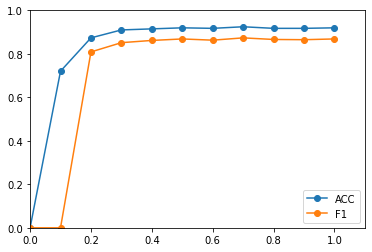

In [126]:
X = df["train_set_ratio"]
y1 = df["Accuracy"]
y2 = df["F1-score"]

plt.plot(X, y1, '-o', label='ACC')
plt.plot(X, y2, '-o', label='F1')
plt.xlim([0.0, 1.1])      
plt.ylim([0.0, 1])
plt.legend()
plt.show()